In [1]:
import tensorflow as tf
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os


In [2]:
# Constants
IMG_HEIGHT, IMG_WIDTH = 331, 331
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001
MOMENTUM = 0.9
MODEL_SAVE_PATH = "nasnet_large_finetuned.h5"
FEATURE_EXTRACTOR_SAVE_PATH = "nasnet_large_feature_extractor.h5"

In [3]:
def create_data_generators(dataset_path, img_height, img_width, batch_size):
    """
    Creates data generators for training and validation with augmentation.
    """
    datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=False,
        validation_split=0.2
    )

    train_generator = datagen.flow_from_directory(
        directory=os.path.join(dataset_path, "Train"),
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="categorical",
        subset="training",
        shuffle=True
    )

    validation_generator = datagen.flow_from_directory(
        directory=os.path.join(dataset_path, "Test"),
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode="categorical",
        subset="validation"
    )

    return train_generator, validation_generator

In [4]:
def build_model(input_shape, num_classes, learning_rate, momentum):
    """
    Builds and compiles the NASNetLarge model with custom classification layers.
    """
    # Load the pre-trained NASNetLarge model without the top layers
    base_model = NASNetLarge(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False  # Freeze the convolutional base

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output_layer = Dense(num_classes, activation="softmax")(x)

    # Define the model
    model = Model(inputs=base_model.input, outputs=output_layer)

    # Compile the model
    model.compile(
        optimizer=SGD(learning_rate=learning_rate, momentum=momentum),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model, base_model

In [5]:
def save_model(model, file_path):
    """
    Saves the trained model to the specified file path.
    """
    try:
        model.save(file_path)
        print(f"Model saved successfully at {file_path}")
    except Exception as e:
        print(f"Error saving model: {e}")


In [6]:
def save_feature_extractor(base_model, file_path):
    """
    Saves the feature extractor (base model) for reuse.
    """
    try:
        base_model.save(file_path)
        print(f"Feature extractor saved successfully at {file_path}")
    except Exception as e:
        print(f"Error saving feature extractor: {e}")

In [7]:
def plot_training_history(history):
    """
    Plots training and validation accuracy and loss.
    """
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()


In [8]:
# Dataset path
dataset_path = "/kaggle/input/affectnet-cleaned"


In [9]:
# Create data generators
train_generator, validation_generator = create_data_generators(
    dataset_path, IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE
)


Found 8331 images belonging to 6 classes.
Found 914 images belonging to 6 classes.


In [10]:
# Build the model
model, base_model = build_model(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    num_classes=train_generator.num_classes,
    learning_rate=LEARNING_RATE,
    momentum=MOMENTUM
)

343610240/343610240 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
# Display the model summary
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 331, 331, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv1 (Conv2D)       │ (None, 165, 165, 96)   │          2,592 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn1                  │ (None, 165, 165, 96)   │            384 │ stem_conv1[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 165, 165, 96)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_conv_1_stem_1   │ (None, 165, 165, 42)   │          4,032 │ activation[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_bn_1_stem_1     │ (None, 165, 165, 42)   │            168 │ reduction_conv_1_stem… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 165, 165, 42)   │              0 │ reduction_bn_1_stem_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 165, 165, 96)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 169, 169, 42)   │              0 │ activation_1[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 171, 171, 96)   │              0 │ activation_3[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 83, 83, 42)     │          2,814 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 83, 83, 42)     │          8,736 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 83, 83, 42)     │            168 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 83, 83, 42)     │            168 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 83, 83, 42)     │              0 │ separable_conv_1_bn_r… │
├──────────────────────

 Total params: 84,941,016 (324.02 MB)

 Trainable params: 24,198 (94.52 KB)

 Non-trainable params: 84,916,818 (323.93 MB)

None


In [12]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


261/261 ━━━━━━━━━━━━━━━━━━━━ 371s 1s/step - accuracy: 0.2492 - loss: 1.7527 - val_accuracy: 0.3326 - val_loss: 1.6316
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 237s 886ms/step - accuracy: 0.3735 - loss: 1.5771 - val_accuracy: 0.3742 - val_loss: 1.5540
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 236s 884ms/step - accuracy: 0.4047 - loss: 1.4918 - val_accuracy: 0.3939 - val_loss: 1.4977
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 236s 882ms/step - accuracy: 0.4223 - loss: 1.4540 - val_accuracy: 0.3950 - val_loss: 1.4767
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 235s 878ms/step - accuracy: 0.4367 - loss: 1.4027 - val_accuracy: 0.4048 - val_loss: 1.4505
Epoch 6/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 235s 879ms/step - accuracy: 0.4485 - loss: 1.3773 - val_accuracy: 0.4212 - val_loss: 1.4296
Epoch 7/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 234s 876ms/step - accuracy: 0.4498 - loss: 1.3462 - val_accuracy: 0.4289 - val_loss: 1.4032
Epoch 8/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 235s 879ms/step - accuracy: 0.4423 - loss: 1.3271 

In [13]:
# Save the full model
save_model(model, MODEL_SAVE_PATH)

Model saved successfully at nasnet_large_finetuned.h5


In [14]:
# Display the model summary
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 331, 331, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv1 (Conv2D)       │ (None, 165, 165, 96)   │          2,592 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn1                  │ (None, 165, 165, 96)   │            384 │ stem_conv1[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 165, 165, 96)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_conv_1_stem_1   │ (None, 165, 165, 42)   │          4,032 │ activation[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reduction_bn_1_stem_1     │ (None, 165, 165, 42)   │            168 │ reduction_conv_1_stem… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 165, 165, 42)   │              0 │ reduction_bn_1_stem_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 165, 165, 96)   │              0 │ stem_bn1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 169, 169, 42)   │              0 │ activation_1[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_pad_red… │ (None, 171, 171, 96)   │              0 │ activation_3[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 83, 83, 42)     │          2,814 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_reducti… │ (None, 83, 83, 42)     │          8,736 │ separable_conv_1_pad_… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 83, 83, 42)     │            168 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv_1_bn_redu… │ (None, 83, 83, 42)     │            168 │ separable_conv_1_redu… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 83, 83, 42)     │              0 │ separable_conv_1_bn_r… │
├──────────────────────

 Total params: 84,965,216 (324.12 MB)

 Trainable params: 24,198 (94.52 KB)

 Non-trainable params: 84,916,818 (323.93 MB)

 Optimizer params: 24,200 (94.54 KB)

None


In [15]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 239s 896ms/step - accuracy: 0.5356 - loss: 1.1076 - val_accuracy: 0.4912 - val_loss: 1.3314
Epoch 2/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 236s 882ms/step - accuracy: 0.5276 - loss: 1.1198 - val_accuracy: 0.4836 - val_loss: 1.3325
Epoch 3/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 237s 886ms/step - accuracy: 0.5164 - loss: 1.1222 - val_accuracy: 0.4945 - val_loss: 1.3167
Epoch 4/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 238s 890ms/step - accuracy: 0.5333 - loss: 1.1150 - val_accuracy: 0.4902 - val_loss: 1.3387
Epoch 5/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 240s 896ms/step - accuracy: 0.5376 - loss: 1.1191 - val_accuracy: 0.4803 - val_loss: 1.3338
Epoch 6/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 239s 894ms/step - accuracy: 0.5139 - loss: 1.1358 - val_accuracy: 0.4770 - val_loss: 1.3469
Epoch 7/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 236s 884ms/step - accuracy: 0.5337 - loss: 1.1123 - val_accuracy: 0.4869 - val_loss: 1.3474
Epoch 8/50
261/261 ━━━━━━━━━━━━━━━━━━━━ 238s 890ms/step - accuracy: 0.5237 -

In [16]:
# Save the full model
save_model(model, MODEL_SAVE_PATH)

Model saved successfully at nasnet_large_finetuned.h5


In [17]:
# Save the feature extractor (base model)
save_feature_extractor(base_model, FEATURE_EXTRACTOR_SAVE_PATH)

Feature extractor saved successfully at nasnet_large_feature_extractor.h5


In [18]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator, verbose=1)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 817ms/step - accuracy: 0.4934 - loss: 1.3301
Validation Accuracy: 49.89%


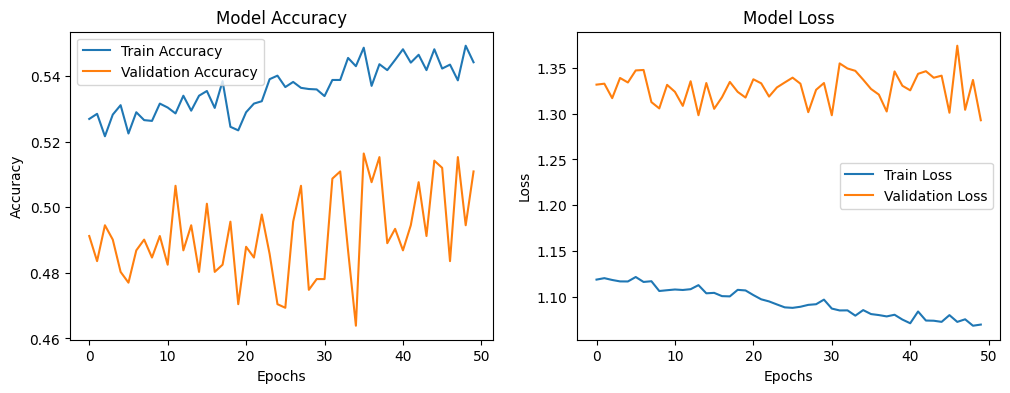

In [19]:
# Plot training history
plot_training_history(history)

In [20]:
train_path = os.path.join(dataset_path, "Train")
test_path = os.path.join(dataset_path, "Test")

print("Train Path:", train_path)
print("Train Path Exists:", os.path.exists(train_path))
print("Test Path:", test_path)
print("Test Path Exists:", os.path.exists(test_path))


Train Path: /kaggle/input/affectnet-cleaned/Train
Train Path Exists: True
Test Path: /kaggle/input/affectnet-cleaned/Test
Test Path Exists: True
